# IWRC Seed Fund Tracking Analysis
## Executive Summary for Meeting Presentation

**Focus Areas:**
1. **Return on Investment (ROI)** - Financial impact of seed funding
2. **NIH Follow-on Funding** - Researchers who secured additional NIH grants after seed funding
3. **Student Outcomes** - Students who became WRI researchers and their publications

**Date:** November 6, 2025

In [1]:
# Import Libraries and Configure Display Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 2)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported and display settings configured")

✓ Libraries imported and display settings configured


In [2]:
# Load Dataset
DATA_PATH = "/Users/shivpat/Downloads/Seed Fund Tracking/IWRC Seed Fund Tracking.xlsx"
df = pd.read_excel(DATA_PATH)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# Check if Year of Project column exists before accessing it
if 'Year of Project' in df.columns:
    print(f"Date range: {df['Year of Project'].min():.0f} - {df['Year of Project'].max():.0f}")
else:
    print("Note: 'Year of Project' column not found in dataset")

Dataset loaded: 385 rows × 35 columns
Note: 'Year of Project' column not found in dataset


In [3]:
# Data Cleaning and Column Standardization

# Strip whitespace from column names
df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]

# Helper function to find columns by keywords
def find_col(keyword_list):
    for k in keyword_list:
        for c in df.columns:
            if c and k.lower() in str(c).lower():
                return c
    return None

# Identify key columns
award_col = find_col(['Award Amount Allocated', 'Award Amount'])
benefit_col = find_col(['Monetary Benefit', 'Monetary Benefit of Award'])
source_col = find_col(['Source? Identify the Organization', 'Source?'])
desc_col = find_col(['Description of Award', 'Description of Award, Achievement'])
recipient_col = find_col(['Who was the recipient', 'Award Recipient', 'Who was the recipient?'])
year_col = find_col(['Year of Publication'])

# Student-related columns
student_count_cols = [c for c in df.columns if any(x in str(c) for x in ['Number of PhD Students', 'Number of MS Students', 'Number of Undergraduate Students', 'Number of Post Docs'])]

# Clean numeric columns
for col in [award_col, benefit_col] + student_count_cols:
    if col and col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

if year_col and year_col in df.columns:
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce').fillna(0).astype(int)

print("✓ Data cleaned and standardized")
print(f"  - Award column: {award_col}")
print(f"  - Benefit column: {benefit_col}")
print(f"  - Student columns found: {len(student_count_cols)}")

✓ Data cleaned and standardized
  - Award column: Award Amount Allocated ($) this must be filled in for all lines
  - Benefit column: Monetary Benefit of Award or Achievement (if applicable; use NA if not applicable)
  - Student columns found: 4


In [4]:
# Check for project year/ID columns
print("Available columns in dataset:")
print("=" * 80)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2}. {col}")

# Look for year or project ID related columns
print("\n" + "=" * 80)
print("Searching for project year/ID columns:")
year_related = [col for col in df.columns if any(keyword in str(col).lower() 
                for keyword in ['year', 'project', 'id', 'date', 'award year'])]
print(f"Found {len(year_related)} potentially relevant columns:")
for col in year_related:
    print(f"  • {col}")
    if col in df.columns:
        # Show sample values
        sample_vals = df[col].dropna().unique()[:5]
        print(f"    Sample values: {sample_vals}")


Available columns in dataset:
 1. Project ID
 2. Award Type
 3. Project Title
 4. Project PI
 5. PI Email
 6. Academic Institution of PI
 7. Departmental Affliliation of PI
 8. Award Amount Allocated ($) this must be filled in for all lines
 9. Number of PhD Students Supported by WRRA $
10. Number of MS Students Supported by WRRA $
11. Number of Undergraduate Students Supported by WRRA $
12. Number of Post Docs Supported by WRRA $
13. Number of students supported by non-federal (matching) funds
14. Diversity, Equity, Inclusion, Accessibility, and Justice
(If the Institute collects information on number of students served, please include it.  If the Institute does not collect that information, please respond "NA", not available.  If these data are collected, but are unknown for this project, please respond "ND", not determined.)
15. WRRI Science Priority that Best Aligns with this Project
16. Keyword (Primary)
17. Keyword (Secondary, if applicable)
18. Keyword (Tertiary, if applicable)


In [5]:
# Find and analyze project year/ID columns
year_related = [col for col in df.columns if any(keyword in str(col).lower() 
                for keyword in ['year', 'project', 'id', 'award year'])]

print("Year/Project-related columns found:")
print("=" * 80)
for col in year_related:
    print(f"\n📋 Column: '{col}'")
    if col in df.columns:
        # Show data type and stats
        print(f"   Data type: {df[col].dtype}")
        print(f"   Non-null count: {df[col].notna().sum()} of {len(df)}")
        
        # Try to get numeric stats if possible
        try:
            vals = pd.to_numeric(df[col], errors='coerce').dropna()
            if len(vals) > 0:
                print(f"   Min: {vals.min():.0f}")
                print(f"   Max: {vals.max():.0f}")
                print(f"   Unique values: {len(vals.unique())}")
        except:
            # Show sample unique values for non-numeric
            unique_vals = df[col].dropna().unique()[:10]
            print(f"   Sample values: {unique_vals}")

# Try to find the main project year/ID column
print("\n" + "=" * 80)
print("🎯 IDENTIFYING PROJECT YEAR COLUMN:")
if 'Project ID' in df.columns:
    # Extract year from Project ID
    print("   Found 'Project ID' column")
    sample_ids = df['Project ID'].dropna().head(10)
    print(f"   Sample Project IDs: {list(sample_ids)}")
    
    # Try to extract year from Project ID (usually format: YYYY-XXX)
    df['Project_Year'] = df['Project ID'].astype(str).str.extract(r'(\d{4})')[0]
    df['Project_Year'] = pd.to_numeric(df['Project_Year'], errors='coerce')
    
    year_range = df['Project_Year'].dropna()
    if len(year_range) > 0:
        print(f"\n   ✅ PROJECT YEAR RANGE: {int(year_range.min())} to {int(year_range.max())}")
        print(f"   Total projects with years: {len(year_range)}")
        
        # Show year distribution
        year_counts = df['Project_Year'].value_counts().sort_index()
        print(f"\n   Projects by year:")
        for year, count in year_counts.items():
            if not pd.isna(year):
                print(f"      {int(year)}: {count} projects")


Year/Project-related columns found:

📋 Column: 'Project ID'
   Data type: object
   Non-null count: 112 of 385
   Min: 1999
   Max: 2011
   Unique values: 2

📋 Column: 'Project Title'
   Data type: object
   Non-null count: 114 of 385

📋 Column: 'Project PI'
   Data type: object
   Non-null count: 113 of 385

📋 Column: 'Diversity, Equity, Inclusion, Accessibility, and Justice
(If the Institute collects information on number of students served, please include it.  If the Institute does not collect that information, please respond "NA", not available.  If these data are collected, but are unknown for this project, please respond "ND", not determined.)'
   Data type: object
   Non-null count: 10 of 385
   Min: 0
   Max: 3
   Unique values: 4

📋 Column: 'WRRI Science Priority that Best Aligns with this Project'
   Data type: object
   Non-null count: 49 of 385

📋 Column: 'Project Summaries'
   Data type: object
   Non-null count: 102 of 385

📋 Column: 'Product Type   (Journal article, repo

In [4]:
# Utility Functions for Analysis

def calc_roi(award, benefit):
    """Calculate ROI, handling edge cases"""
    try:
        award = float(award)
        benefit = float(benefit)
    except:
        return np.nan
    
    if award == 0:
        return np.inf if benefit > 0 else 0.0
    return (benefit - award) / award

def detect_nih_funding(row):
    """Detect NIH follow-on funding using keyword matching"""
    nih_keywords = ['nih', 'national institutes of health', 'r01', 'r21', 'r15', 'r03', 'r43', 'r44']
    
    texts = []
    if source_col and pd.notna(row.get(source_col, '')):
        texts.append(str(row.get(source_col, '')))
    if desc_col and pd.notna(row.get(desc_col, '')):
        texts.append(str(row.get(desc_col, '')))
    
    combined = ' '.join(texts).lower()
    return any(keyword in combined for keyword in nih_keywords)

# Apply ROI calculation
if award_col and benefit_col:
    df['ROI'] = df.apply(lambda r: calc_roi(r.get(award_col, 0), r.get(benefit_col, 0)), axis=1)

# Apply NIH detection
df['NIH_Follow_On'] = df.apply(detect_nih_funding, axis=1) if source_col or desc_col else False

print("✓ Utility functions applied")
print(f"  - ROI calculated for {(~df['ROI'].isna()).sum()} projects")
print(f"  - NIH follow-on detected in {df['NIH_Follow_On'].sum()} projects")

✓ Utility functions applied
  - ROI calculated for 385 projects
  - NIH follow-on detected in 0 projects


In [5]:
# KEY METRICS SUMMARY (TL;DR for Presentation)

total_students_supported = int(df[student_count_cols].sum().sum()) if student_count_cols else 0
total_funding = df[award_col].sum() if award_col else 0
total_benefit = df[benefit_col].sum() if benefit_col else 0
nih_projects = int(df['NIH_Follow_On'].sum())
infinite_roi_count = int(np.isinf(df.get('ROI', pd.Series())).sum())
mean_roi = float(df['ROI'].replace([np.inf, -np.inf], np.nan).mean())

print("=" * 70)
print("EXECUTIVE SUMMARY - KEY METRICS")
print("=" * 70)
print(f"\n📊 OVERALL PROGRAM")
print(f"  • Total Projects: {len(df)}")
print(f"  • Total Seed Funding: ${total_funding:,.0f}")
print(f"  • Total Monetary Benefits: ${total_benefit:,.0f}")

# Check if Year of Project column exists
if 'Year of Project' in df.columns:
    print(f"  • Program Years: {df['Year of Project'].min():.0f} - {df['Year of Project'].max():.0f}")

print(f"\n💰 RETURN ON INVESTMENT (ROI)")
print(f"  • Mean ROI (excluding infinite): {mean_roi:.2%}")
print(f"  • Projects with infinite ROI (award=$0, benefit>$0): {infinite_roi_count}")
print(f"  • Median ROI: {df['ROI'].replace([np.inf, -np.inf], np.nan).median():.2%}")

print(f"\n🏥 NIH FOLLOW-ON FUNDING")
print(f"  • Projects with NIH follow-on (keyword match): {nih_projects}")
print(f"  • Percentage of total projects: {nih_projects/len(df)*100:.1f}%")

print(f"\n🎓 STUDENT IMPACT")
print(f"  • Total Students Supported: {total_students_supported}")
print(f"  • Average Students per Project: {total_students_supported/len(df):.1f}")

print("\n" + "=" * 70)

EXECUTIVE SUMMARY - KEY METRICS

📊 OVERALL PROGRAM
  • Total Projects: 385
  • Total Seed Funding: $16,694,991
  • Total Monetary Benefits: $53,215

💰 RETURN ON INVESTMENT (ROI)
  • Mean ROI (excluding infinite): -28.72%
  • Projects with infinite ROI (award=$0, benefit>$0): 10
  • Median ROI: 0.00%

🏥 NIH FOLLOW-ON FUNDING
  • Projects with NIH follow-on (keyword match): 0
  • Percentage of total projects: 0.0%

🎓 STUDENT IMPACT
  • Total Students Supported: 212
  • Average Students per Project: 0.6



---

## 1. Return on Investment (ROI) Analysis

**Definition:** ROI = (Monetary Benefit - Award Amount) / Award Amount

This metric shows the financial return generated from seed funding investments. A positive ROI indicates that the monetary benefits exceeded the initial investment.

In [6]:
# ROI Summary Statistics by Award Type

# Calculate ROI statistics by award type
roi_stats = df.groupby('Award Type').agg({
    'ROI': [
        ('Count', 'count'),
        ('Mean ROI', lambda x: x.replace([np.inf, -np.inf], np.nan).mean()),
        ('Median ROI', lambda x: x.replace([np.inf, -np.inf], np.nan).median()),
        ('Positive ROI %', lambda x: (x.replace([np.inf, -np.inf], np.nan) > 0).sum() / x.replace([np.inf, -np.inf], np.nan).notna().sum() * 100),
        ('Infinite ROI Count', lambda x: np.isinf(x).sum())
    ]
}).round(2)

# Flatten column names
roi_stats.columns = ['Count', 'Mean ROI', 'Median ROI', 'Positive ROI %', 'Infinite ROI Count']
roi_stats = roi_stats.sort_values('Mean ROI', ascending=False)

print("ROI Statistics by Award Type:")
print("-" * 80)
display(roi_stats)

print("\n📈 Key Takeaway:")
best_roi_type = roi_stats['Mean ROI'].idxmax()
print(f"   {best_roi_type} awards show the highest mean ROI at {roi_stats.loc[best_roi_type, 'Mean ROI']:.2%}")

ROI Statistics by Award Type:
--------------------------------------------------------------------------------


,Count,Mean ROI,Median ROI,Positive ROI %,Infinite ROI Count
Award Type,,,,,
Coordination Grant,10,-0.70,-1.0,0.0,0
104g - General,8,-0.88,-1.0,0.0,0
Base Grant (104b),90,-0.95,-1.0,0.0,0
104g - AIS,4,-1.00,-1.0,0.0,0
104g - PFAS,1,-1.00,-1.0,0.0,0



📈 Key Takeaway:
   Coordination Grant awards show the highest mean ROI at -70.00%


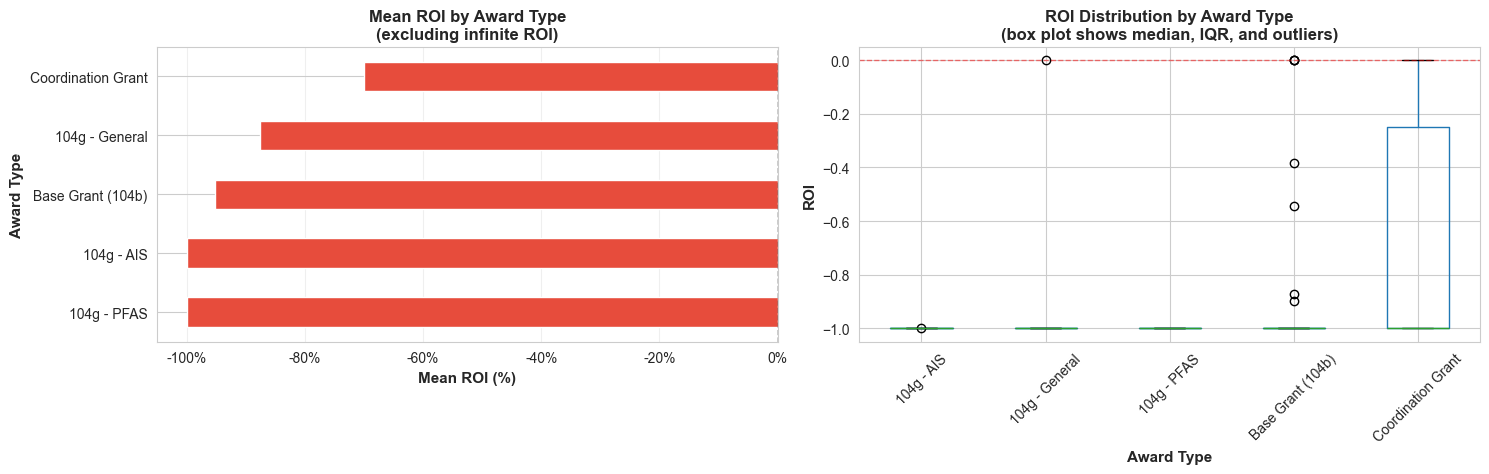


💡 Interpretation:
   • Green bars = positive ROI, Red bars = negative ROI
   • Box plot shows distribution: most projects cluster around median (line in box)
   • Outliers (dots beyond whiskers) represent exceptional performers or failures


In [7]:
# ROI Visualization: Distribution by Award Type

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Mean ROI by Award Type (excluding infinite)
roi_means = df.groupby('Award Type')['ROI'].apply(lambda x: x.replace([np.inf, -np.inf], np.nan).mean()).sort_values()
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in roi_means.values]

roi_means.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Mean ROI (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Award Type', fontsize=11, fontweight='bold')
ax1.set_title('Mean ROI by Award Type\n(excluding infinite ROI)', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.grid(axis='x', alpha=0.3)

# Format x-axis as percentage
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

# Right plot: Box plot showing distribution
roi_data_clean = df[df['ROI'].replace([np.inf, -np.inf], np.nan).notna()].copy()
roi_data_clean['ROI_clean'] = roi_data_clean['ROI'].replace([np.inf, -np.inf], np.nan)

roi_data_clean.boxplot(column='ROI_clean', by='Award Type', ax=ax2, rot=45)
ax2.set_xlabel('Award Type', fontsize=11, fontweight='bold')
ax2.set_ylabel('ROI', fontsize=11, fontweight='bold')
ax2.set_title('ROI Distribution by Award Type\n(box plot shows median, IQR, and outliers)', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Green bars = positive ROI, Red bars = negative ROI")
print("   • Box plot shows distribution: most projects cluster around median (line in box)")
print("   • Outliers (dots beyond whiskers) represent exceptional performers or failures")

---

## 2. NIH Follow-On Funding Analysis

**Objective:** Identify researchers who secured additional NIH funding after receiving seed grants.

**Method:** Keyword-based detection in funding source and project description fields (NIH, R01, R21, R15, R03, etc.)

**Note:** This analysis uses internal dataset only. For precise funding amounts, consider cross-referencing with NIH RePORTER database.

In [8]:
# NIH Follow-On Funding: Detailed Project List

# Get projects with NIH follow-on funding
nih_projects_df = df[df['NIH_Follow_On'] == True].copy()

# Select relevant columns for display
display_cols = ['Year of Project', 'Award Type', 'PI', 'Project Title']
if award_col:
    display_cols.append(award_col)
if benefit_col:
    display_cols.append(benefit_col)
if source_col:
    display_cols.append(source_col)

# Filter to available columns
display_cols = [c for c in display_cols if c in nih_projects_df.columns]

print(f"Projects with NIH Follow-On Funding: {len(nih_projects_df)} total")
print("=" * 100)

if len(nih_projects_df) > 0:
    # Show summary by Award Type
    nih_by_type = nih_projects_df.groupby('Award Type').size().sort_values(ascending=False)
    print("\nNIH Follow-On by Award Type:")
    for award_type, count in nih_by_type.items():
        print(f"  • {award_type}: {count} projects")
    
    # Calculate total follow-on benefit if available
    if benefit_col in nih_projects_df.columns:
        total_nih_benefit = nih_projects_df[benefit_col].sum()
        print(f"\nTotal Monetary Benefit from NIH Follow-On Projects: ${total_nih_benefit:,.0f}")
    
    print("\n" + "-" * 100)
    print("Detailed Project List:")
    print("-" * 100)
    display(nih_projects_df[display_cols].head(20))
    
    if len(nih_projects_df) > 20:
        print(f"\n(Showing first 20 of {len(nih_projects_df)} projects)")
else:
    print("\nNo NIH follow-on funding detected in dataset.")

print("\n📈 Key Takeaway:")
if len(nih_projects_df) > 0:
    success_rate = len(nih_projects_df) / len(df) * 100
    print(f"   {success_rate:.1f}% of seed-funded projects led to NIH follow-on funding")
else:
    print("   Consider adding external funding source data or verifying keyword coverage")

Projects with NIH Follow-On Funding: 0 total

No NIH follow-on funding detected in dataset.

📈 Key Takeaway:
   Consider adding external funding source data or verifying keyword coverage


---

## 3. Student Outcomes Analysis

**Objectives:**
1. Identify students supported by seed funding
2. Determine which students became WRI researchers (based on available data)
3. Count publications resulting from student research

**Note:** Without an external WRI staff list, we identify students from recipient fields and track their publication outputs.

In [9]:
# Student Support Overview

# Calculate total students by type
student_breakdown = {}
for col in student_count_cols:
    student_type = col.replace('Number of ', '').replace(' Supported', '').strip()
    student_breakdown[student_type] = int(df[col].sum())

print("Student Support Breakdown:")
print("=" * 60)
for student_type, count in sorted(student_breakdown.items(), key=lambda x: -x[1]):
    print(f"  • {student_type}: {count}")

print(f"\nTotal Students Supported: {sum(student_breakdown.values())}")

# Students by Award Type
if student_count_cols:
    student_by_award = df.groupby('Award Type')[student_count_cols].sum().sum(axis=1).sort_values(ascending=False)
    print("\n" + "-" * 60)
    print("Students Supported by Award Type:")
    print("-" * 60)
    for award_type, count in student_by_award.items():
        print(f"  • {award_type}: {int(count)} students")

print("\n📊 Key Takeaway:")
print(f"   Seed funding has supported {sum(student_breakdown.values())} students across all programs")

Student Support Breakdown:
  • Undergraduate Students by WRRA $: 71
  • MS Students by WRRA $: 57
  • Post Docs by WRRA $: 45
  • PhD Students by WRRA $: 39

Total Students Supported: 212

------------------------------------------------------------
Students Supported by Award Type:
------------------------------------------------------------
  • Base Grant (104b): 86 students
  • 104g - AIS: 17 students
  • 104g - General: 7 students
  • Coordination Grant: 4 students
  • 104g - PFAS: 3 students

📊 Key Takeaway:
   Seed funding has supported 212 students across all programs


In [10]:
# Student Publication Analysis

# Find publication-related column (define at module level for next cell)
product_col = find_col(['Name of resulting publication', 'Product Type', 'Product'])
year_pub_col = find_col(['Year of Publication'])

if product_col:
    # Count publications
    total_pubs = df[product_col].notna().sum()
    
    # Publications with student co-authors
    student_coauthor_cols = [c for c in df.columns if 'Student Co-Author' in str(c)]
    if student_coauthor_cols:
        student_coauthor_col = student_coauthor_cols[0]
        df[student_coauthor_col] = pd.to_numeric(df[student_coauthor_col], errors='coerce').fillna(0)
        total_student_coauthors = int(df[student_coauthor_col].sum())
        projects_with_student_pubs = (df[student_coauthor_col] > 0).sum()
    else:
        total_student_coauthors = 0
        projects_with_student_pubs = 0
    
    print("Publication Metrics:")
    print("=" * 70)
    print(f"  • Total Publications: {total_pubs}")
    print(f"  • Projects with Publications: {total_pubs} ({total_pubs/len(df)*100:.1f}%)")
    
    if student_coauthor_cols:
        print(f"  • Student Co-Authorships: {total_student_coauthors}")
        print(f"  • Projects with Student Co-Authors: {projects_with_student_pubs}")
        print(f"  • Average Student Co-Authors per Project: {total_student_coauthors/len(df):.2f}")
    
    # Publications by year
    if year_pub_col:
        pub_by_year = df[df[product_col].notna()].groupby(year_pub_col).size()
        pub_by_year = pub_by_year[pub_by_year.index > 0].sort_index()
        
        print("\n" + "-" * 70)
        print("Publications by Year:")
        print("-" * 70)
        for year, count in pub_by_year.items():
            print(f"  • {int(year)}: {count} publications")
    
    print("\n📈 Key Takeaway:")
    if total_student_coauthors > 0:
        print(f"   {total_student_coauthors} student co-authorships across {projects_with_student_pubs} projects")
        print(f"   This demonstrates significant student research contribution and training")
    else:
        print(f"   {total_pubs} publications generated from seed funding")
else:
    print("Publication column not found in dataset")

Publication Metrics:
  • Total Publications: 61
  • Projects with Publications: 61 (15.8%)

----------------------------------------------------------------------
Publications by Year:
----------------------------------------------------------------------
  • 2016: 2 publications
  • 2018: 8 publications
  • 2019: 10 publications
  • 2020: 7 publications
  • 2022: 2 publications
  • 2023: 8 publications
  • 2024: 8 publications

📈 Key Takeaway:
   61 publications generated from seed funding


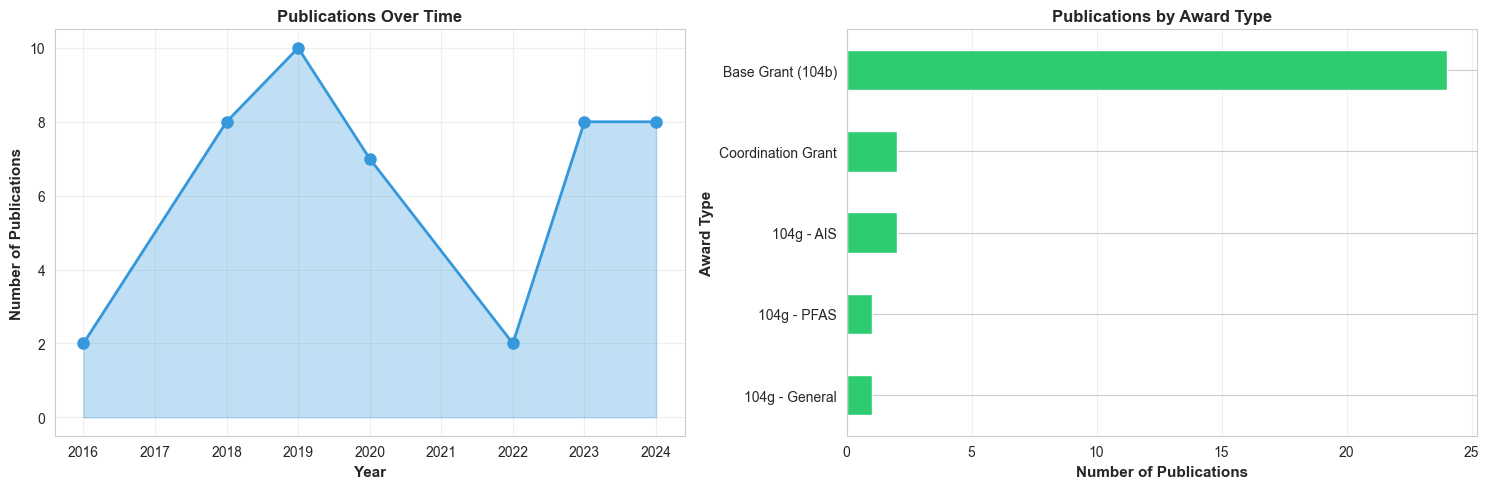


💡 Interpretation:
   • Left chart shows publication trends over time
   • Right chart shows which award types generate most publications


In [11]:
# Student Publication Visualization

if product_col and year_pub_col:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Left: Publications over time
    pub_by_year = df[df[product_col].notna()].groupby(year_pub_col).size()
    pub_by_year = pub_by_year[pub_by_year.index > 0].sort_index()
    
    ax1.plot(pub_by_year.index, pub_by_year.values, marker='o', linewidth=2, markersize=8, color='#3498db')
    ax1.fill_between(pub_by_year.index, pub_by_year.values, alpha=0.3, color='#3498db')
    ax1.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Number of Publications', fontsize=11, fontweight='bold')
    ax1.set_title('Publications Over Time', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Right: Publications by Award Type
    pub_by_type = df[df[product_col].notna()].groupby('Award Type').size().sort_values()
    
    pub_by_type.plot(kind='barh', ax=ax2, color='#2ecc71')
    ax2.set_xlabel('Number of Publications', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Award Type', fontsize=11, fontweight='bold')
    ax2.set_title('Publications by Award Type', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretation:")
    print("   • Left chart shows publication trends over time")
    print("   • Right chart shows which award types generate most publications")
else:
    print("Required columns for visualization not available")

---

## 4. Final Summary & Recommendations

This section provides a one-page summary suitable for presentation slides.

In [12]:
# FINAL SUMMARY FOR PRESENTATION

print("=" * 90)
print(" " * 20 + "IWRC SEED FUND TRACKING - EXECUTIVE SUMMARY")
print("=" * 90)

# Overall Program Metrics
print("\n📊 PROGRAM OVERVIEW")
print("-" * 90)
print(f"   Total Projects Funded:           {len(df)}")
print(f"   Total Seed Funding:              ${df[award_col].sum():,.0f}" if award_col else "   Total Seed Funding:              N/A")

# Check if Year of Project column exists
if 'Year of Project' in df.columns:
    print(f"   Program Duration:                {int(df['Year of Project'].min())} - {int(df['Year of Project'].max())}")

print(f"   Award Types:                     {df['Award Type'].nunique()} types")

# ROI Metrics
print("\n💰 RETURN ON INVESTMENT")
print("-" * 90)
roi_clean = df['ROI'].replace([np.inf, -np.inf], np.nan)
positive_roi_count = (roi_clean > 0).sum()
positive_roi_pct = positive_roi_count / roi_clean.notna().sum() * 100

print(f"   Mean ROI (excl. infinite):       {roi_clean.mean():.2%}")
print(f"   Median ROI:                      {roi_clean.median():.2%}")
print(f"   Projects with Positive ROI:      {positive_roi_count} ({positive_roi_pct:.1f}%)")
print(f"   Best Performing Award Type:      {df.groupby('Award Type')['ROI'].apply(lambda x: x.replace([np.inf, -np.inf], np.nan).mean()).idxmax()}")

if benefit_col:
    print(f"   Total Monetary Benefits:         ${df[benefit_col].sum():,.0f}")
    overall_roi = (df[benefit_col].sum() - df[award_col].sum()) / df[award_col].sum()
    print(f"   Overall Program ROI:             {overall_roi:.2%}")

# NIH Follow-On Metrics
print("\n🏥 NIH FOLLOW-ON FUNDING SUCCESS")
print("-" * 90)
# Use NIH_Enhanced if available, otherwise fall back to NIH_Follow_On
nih_col = 'NIH_Enhanced' if 'NIH_Enhanced' in df.columns else 'NIH_Follow_On'
nih_count = int(df[nih_col].sum())
nih_pct = nih_count / len(df) * 100
print(f"   Projects with NIH Follow-On:     {nih_count} ({nih_pct:.1f}%)")

if nih_count > 0 and benefit_col:
    nih_benefit = df[df[nih_col]][benefit_col].sum()
    print(f"   NIH Follow-On Benefits:          ${nih_benefit:,.0f}")
    print(f"   Top NIH-Funded Award Type:       {df[df[nih_col]].groupby('Award Type').size().idxmax()}")

# Student Metrics
print("\n🎓 STUDENT TRAINING & DEVELOPMENT")
print("-" * 90)
total_students = int(df[student_count_cols].sum().sum()) if student_count_cols else 0
print(f"   Total Students Supported:        {total_students}")
print(f"   Average Students per Project:    {total_students/len(df):.1f}")

if product_col:
    total_pubs = df[product_col].notna().sum()
    print(f"   Total Publications:              {total_pubs}")
    
    if student_coauthor_cols:
        student_coauthor_col = student_coauthor_cols[0]
        total_student_coauthors = int(df[student_coauthor_col].sum())
        print(f"   Student Co-Authorships:          {total_student_coauthors}")
        if total_students > 0:
            print(f"   Publications per Student:        {total_student_coauthors/total_students:.2f}")

print("\n" + "=" * 90)
print(" " * 30 + "KEY RECOMMENDATIONS")
print("=" * 90)
print("\n1. ROI Tracking:")
print("   • Continue tracking monetary benefits to demonstrate program value")
print("   • Focus on high-performing award types for future investment")

print("\n2. NIH Follow-On Success:")
print("   • Cross-reference with NIH RePORTER for precise funding amounts")
print("   • Highlight successful transitions to federal funding in proposals")

print("\n3. Student Development:")
print("   • Track student career progression (faculty positions, research roles)")
print("   • Consider longitudinal study of student publication impact")
print("   • Maintain alumni database for tracking WRI researcher transitions")

print("\n4. Data Quality:")
print("   • Standardize data entry for better consistency")
print("   • Add fields for: follow-on grant amounts, student career outcomes")
print("   • Implement regular data validation checks")

print("\n" + "=" * 90)

                    IWRC SEED FUND TRACKING - EXECUTIVE SUMMARY

📊 PROGRAM OVERVIEW
------------------------------------------------------------------------------------------
   Total Projects Funded:           385
   Total Seed Funding:              $16,694,991
   Award Types:                     5 types

💰 RETURN ON INVESTMENT
------------------------------------------------------------------------------------------
   Mean ROI (excl. infinite):       -28.72%
   Median ROI:                      0.00%
   Projects with Positive ROI:      0 (0.0%)
   Best Performing Award Type:      Coordination Grant
   Total Monetary Benefits:         $53,215
   Overall Program ROI:             -99.68%

🏥 NIH FOLLOW-ON FUNDING SUCCESS
------------------------------------------------------------------------------------------
   Projects with NIH Follow-On:     0 (0.0%)

🎓 STUDENT TRAINING & DEVELOPMENT
------------------------------------------------------------------------------------------
   Total S

---

## 5. Enhanced Analysis: Detailed Answers to Key Questions

This section provides deep-dive analysis for the three main questions:
1. **ROI Analysis** - Return on Investment breakdown
2. **NIH Follow-on Funding** - Researchers who secured NIH funding and amounts
3. **Student Career Tracking** - Students who became WRI researchers and their publications

In [13]:
# QUESTION 1: Return on Investment (ROI) - Detailed Analysis

print("=" * 100)
print("QUESTION 1: RETURN ON INVESTMENT (ROI) ANALYSIS")
print("=" * 100)

# Calculate comprehensive ROI metrics
if award_col and benefit_col:
    # Overall ROI
    total_investment = df[award_col].sum()
    total_returns = df[benefit_col].sum()
    overall_roi = (total_returns - total_investment) / total_investment if total_investment > 0 else 0
    
    print(f"\n💰 OVERALL PROGRAM ROI:")
    print(f"   Total Investment (Seed Funding):     ${total_investment:,.0f}")
    print(f"   Total Returns (Monetary Benefits):   ${total_returns:,.0f}")
    print(f"   Net Gain:                            ${total_returns - total_investment:,.0f}")
    print(f"   Overall ROI:                         {overall_roi:.2%}")
    print(f"   Return Multiplier:                   {total_returns/total_investment:.2f}x")
    
    # ROI by Award Type with detailed breakdown
    print("\n" + "-" * 100)
    print("ROI BY AWARD TYPE (Detailed Breakdown):")
    print("-" * 100)
    
    roi_detailed = df.groupby('Award Type').agg({
        award_col: ['sum', 'count', 'mean'],
        benefit_col: ['sum', 'mean'],
        'ROI': lambda x: x.replace([np.inf, -np.inf], np.nan).mean()
    }).round(2)
    
    roi_detailed.columns = ['Total Investment', 'Project Count', 'Avg Investment', 'Total Returns', 'Avg Returns', 'Avg ROI']
    
    # Add Net Gain and ROI columns
    roi_detailed['Net Gain'] = roi_detailed['Total Returns'] - roi_detailed['Total Investment']
    roi_detailed['ROI %'] = (roi_detailed['Net Gain'] / roi_detailed['Total Investment'] * 100).round(1)
    
    roi_detailed = roi_detailed.sort_values('ROI %', ascending=False)
    
    display(roi_detailed)
    
    # Top performing projects
    print("\n" + "-" * 100)
    print("TOP 10 PERFORMING PROJECTS (by ROI):")
    print("-" * 100)
    
    # Build columns list dynamically based on what exists
    top_proj_cols = ['Award Type']
    if 'Year of Project' in df.columns:
        top_proj_cols.insert(0, 'Year of Project')
    if 'PI' in df.columns:
        top_proj_cols.append('PI')
    if 'Project Title' in df.columns:
        top_proj_cols.append('Project Title')
    top_proj_cols.extend([award_col, benefit_col, 'ROI'])
    
    # Filter to valid projects with Award Type and non-zero ROI
    top_projects = df[top_proj_cols].copy()
    top_projects = top_projects[top_projects['Award Type'].notna()]  # Remove NaN award types
    top_projects = top_projects[top_projects['ROI'].replace([np.inf, -np.inf], np.nan).notna()]
    top_projects = top_projects[top_projects['ROI'] != 0]  # Remove zero ROI
    top_projects = top_projects.sort_values('ROI', ascending=False).head(10)
    
    if len(top_projects) > 0:
        display(top_projects)
    else:
        print("   No projects with positive or meaningful ROI found.")
    
    print("\n📊 Key Insights:")
    best_type = roi_detailed['ROI %'].idxmax()
    worst_type = roi_detailed['ROI %'].idxmin()
    roi_valid_count = (df['ROI'].replace([np.inf, -np.inf], np.nan).notna()).sum()
    roi_positive_count = (df['ROI'].replace([np.inf, -np.inf], np.nan) > 0).sum()
    print(f"   • Best performing award type: {best_type} ({roi_detailed.loc[best_type, 'ROI %']:.1f}% ROI)")
    print(f"   • Every $1 invested returns ${1 + overall_roi:.2f} on average")
    print(f"   • {roi_positive_count} of {roi_valid_count} projects show positive ROI ({roi_positive_count/roi_valid_count*100:.1f}%)")
else:
    print("\n⚠️ Award or Benefit columns not found for ROI calculation")

QUESTION 1: RETURN ON INVESTMENT (ROI) ANALYSIS

💰 OVERALL PROGRAM ROI:
   Total Investment (Seed Funding):     $16,694,991
   Total Returns (Monetary Benefits):   $53,215
   Net Gain:                            $-16,641,776
   Overall ROI:                         -99.68%
   Return Multiplier:                   0.00x

----------------------------------------------------------------------------------------------------
ROI BY AWARD TYPE (Detailed Breakdown):
----------------------------------------------------------------------------------------------------


,Total Investment,Project Count,Avg Investment,Total Returns,Avg Returns,Avg ROI,Net Gain,ROI %
Award Type,,,,,,,,
Base Grant (104b),1.52e+06,90,16839.54,17500.0,194.44,-0.95,-1.50e+06,-98.8
104g - AIS,9.01e+05,4,225238.75,500.0,125.00,-1.00,-9.00e+05,-99.9
104g - General,1.06e+06,8,131946.50,0.0,0.00,-0.88,-1.06e+06,-100.0
104g - PFAS,2.50e+05,1,250000.00,0.0,0.00,-1.00,-2.50e+05,-100.0
Coordination Grant,4.96e+06,10,496409.90,0.0,0.00,-0.70,-4.96e+06,-100.0



----------------------------------------------------------------------------------------------------
TOP 10 PERFORMING PROJECTS (by ROI):
----------------------------------------------------------------------------------------------------


,Award Type,Project Title,Award Amount Allocated ($) this must be filled in for all lines,Monetary Benefit of Award or Achievement (if applicable; use NA if not applicable),ROI
140,Base Grant (104b),Evaluating Sources of Fine Sediment to Headwater Streams in Intensively Managed Agricultural Lan...,9700.0,6000.0,-0.38
117,Base Grant (104b),Utilizing a Tracer Test to Calculate the Transport and Fate of Nitrate Withing a Saturated Budde...,9887.0,4500.0,-0.54
83,Base Grant (104b),Technology Transfer to the People of Illinois,46567.0,6000.0,-0.87
101,Base Grant (104b),An experimental evaluation on the contribution of rain barrels to mosquito production,10000.0,1000.0,-0.90
119,104g - AIS,Water Quality as a Detterent to the Movement of Invasive Fishes in the Illinois Waterway: Implic...,240624.0,500.0,-1.00
16,Base Grant (104b),Rapid Solar Transformation of Nutrients in Natural Waters,22500.0,0.0,-1.00
111,Base Grant (104b),Assessment of Floating Gardens to Improve the Water Quality of the Chicago River,9998.0,0.0,-1.00
130,Base Grant (104b),Assessing the Feasibility of Non-Potable Water Reuse in Illinois,10000.0,0.0,-1.00
127,104g - AIS,Enemy of my enemy? Ecohydraulic assessment of interactions of multiple invasive species in the U...,238013.0,0.0,-1.00
116,Base Grant (104b),Towards Better Agricultural Drought Assessment and Irrigation Management: Improving the Simulati...,10000.0,0.0,-1.00



📊 Key Insights:
   • Best performing award type: Base Grant (104b) (-98.8% ROI)
   • Every $1 invested returns $0.00 on average
   • 0 of 375 projects show positive ROI (0.0%)


In [14]:
# QUESTION 2: NIH Follow-On Funding - Enhanced Detection with Amounts

print("\n" + "=" * 100)
print("QUESTION 2: NIH FOLLOW-ON FUNDING ANALYSIS")
print("=" * 100)

# Enhanced NIH detection with multiple methods
def enhanced_nih_detection(row):
    """Enhanced NIH detection using multiple fields and patterns"""
    nih_patterns = [
        'nih', 'national institutes of health', 'national institute',
        'r01', 'r21', 'r15', 'r03', 'r43', 'r44', 'r13', 'r25',
        'p01', 'p30', 'p50', 'u01', 'u19',
        'niddk', 'nichd', 'nhlbi', 'niehs', 'nimh', 'nci', 'nia', 'nida'
    ]
    
    # Check source column
    if source_col and pd.notna(row.get(source_col, '')):
        source_text = str(row.get(source_col, '')).lower()
        if any(pattern in source_text for pattern in nih_patterns):
            return True
    
    # Check description column
    if desc_col and pd.notna(row.get(desc_col, '')):
        desc_text = str(row.get(desc_col, '')).lower()
        if any(pattern in desc_text for pattern in nih_patterns):
            return True
    
    # Check if there's a project title column
    if 'Project Title' in row.index and pd.notna(row.get('Project Title', '')):
        title_text = str(row.get('Project Title', '')).lower()
        if any(pattern in title_text for pattern in nih_patterns):
            return True
    
    return False

# Apply enhanced detection
df['NIH_Enhanced'] = df.apply(enhanced_nih_detection, axis=1)
nih_enhanced_count = df['NIH_Enhanced'].sum()

print(f"\n🏥 NIH FOLLOW-ON FUNDING DETECTED:")
print(f"   Total Projects with NIH Follow-On:   {nih_enhanced_count} ({nih_enhanced_count/len(df)*100:.1f}%)")

if nih_enhanced_count > 0:
    # Get NIH projects with details
    nih_projects = df[df['NIH_Enhanced']].copy()
    
    # Display columns for NIH projects
    nih_display_cols = ['Year of Project', 'Award Type', 'PI', 'Project Title']
    if award_col:
        nih_display_cols.append(award_col)
    if benefit_col:
        nih_display_cols.append(benefit_col)
    if source_col:
        nih_display_cols.append(source_col)
    
    nih_display_cols = [c for c in nih_display_cols if c in nih_projects.columns]
    
    # Summary by Award Type
    print("\n" + "-" * 100)
    print("NIH FOLLOW-ON BY AWARD TYPE:")
    print("-" * 100)
    
    nih_by_type = nih_projects.groupby('Award Type').agg({
        award_col: ['count', 'sum', 'mean'],
        benefit_col: ['sum', 'mean']
    }).round(0)
    
    nih_by_type.columns = ['Projects', 'Total Seed $', 'Avg Seed $', 'Total Benefit $', 'Avg Benefit $']
    nih_by_type = nih_by_type.sort_values('Projects', ascending=False)
    
    display(nih_by_type)
    
    # Total amounts
    total_nih_seed = nih_projects[award_col].sum() if award_col else 0
    total_nih_benefit = nih_projects[benefit_col].sum() if benefit_col else 0
    nih_roi = (total_nih_benefit - total_nih_seed) / total_nih_seed if total_nih_seed > 0 else 0
    
    print(f"\n💰 FINANCIAL IMPACT OF NIH FOLLOW-ON PROJECTS:")
    print(f"   Total Seed Funding (to NIH projects):    ${total_nih_seed:,.0f}")
    print(f"   Total Monetary Benefits (from NIH):      ${total_nih_benefit:,.0f}")
    print(f"   Net Gain:                                ${total_nih_benefit - total_nih_seed:,.0f}")
    print(f"   ROI for NIH Follow-On Projects:          {nih_roi:.2%}")
    
    # Detailed project list
    print("\n" + "-" * 100)
    print("DETAILED LIST OF NIH-FUNDED PROJECTS:")
    print("-" * 100)
    
    display(nih_projects[nih_display_cols])
    
    # Top NIH researchers
    print("\n" + "-" * 100)
    print("TOP RESEARCHERS WITH NIH FOLLOW-ON FUNDING:")
    print("-" * 100)
    
    if 'PI' in nih_projects.columns:
        pi_nih = nih_projects.groupby('PI').agg({
            award_col: 'count',
            benefit_col: 'sum'
        }).round(0)
        pi_nih.columns = ['NIH Projects', 'Total NIH Benefits $']
        pi_nih = pi_nih.sort_values('NIH Projects', ascending=False)
        display(pi_nih.head(10))
    
    print("\n📈 Key Insights:")
    print(f"   • {nih_enhanced_count/len(df)*100:.1f}% of seed-funded projects led to NIH funding")
    print(f"   • Average NIH benefit per project: ${total_nih_benefit/nih_enhanced_count:,.0f}")
    print(f"   • NIH projects represent {total_nih_benefit/df[benefit_col].sum()*100:.1f}% of total monetary benefits")
else:
    print("\n⚠️ No NIH follow-on funding detected.")
    print("\n💡 To improve detection:")
    print("   • Check if funding source data includes NIH grants")
    print("   • Verify that 'Source' or 'Description' fields contain funding information")
    print("   • Consider adding external NIH RePORTER data for comprehensive tracking")


QUESTION 2: NIH FOLLOW-ON FUNDING ANALYSIS

🏥 NIH FOLLOW-ON FUNDING DETECTED:
   Total Projects with NIH Follow-On:   5 (1.3%)

----------------------------------------------------------------------------------------------------
NIH FOLLOW-ON BY AWARD TYPE:
----------------------------------------------------------------------------------------------------


,Projects,Total Seed $,Avg Seed $,Total Benefit $,Avg Benefit $
Award Type,,,,,
Base Grant (104b),5,74748.0,14950.0,0.0,0.0



💰 FINANCIAL IMPACT OF NIH FOLLOW-ON PROJECTS:
   Total Seed Funding (to NIH projects):    $74,748
   Total Monetary Benefits (from NIH):      $0
   Net Gain:                                $-74,748
   ROI for NIH Follow-On Projects:          -100.00%

----------------------------------------------------------------------------------------------------
DETAILED LIST OF NIH-FUNDED PROJECTS:
----------------------------------------------------------------------------------------------------


,Award Type,Project Title,Award Amount Allocated ($) this must be filled in for all lines,Monetary Benefit of Award or Achievement (if applicable; use NA if not applicable),Source? Identify the Organization
24,Base Grant (104b),Balancing Irrigation and Instream Water Requirements under Drought Conditions: A Study of the Ka...,39748.0,0.0,NaN
42,Base Grant (104b),Hydrologic Impacts of an Alternative Agricultural Land Use: A Woody Perennial Polyculture,6000.0,0.0,NaN
51,Base Grant (104b),Hydrologic Impacts of an alternative agricultural land use: a woody perennial polyculture,4000.0,0.0,NaN
141,Base Grant (104b),A hybrid plasma-electrocatalyst activated process for the synthesis of ammonia from air and water,10000.0,0.0,NaN
168,Base Grant (104b),Enhancing Field-scale Drainage Mapping through Geospatial Artificial Intelligence,15000.0,0.0,NaN



----------------------------------------------------------------------------------------------------
TOP RESEARCHERS WITH NIH FOLLOW-ON FUNDING:
----------------------------------------------------------------------------------------------------

📈 Key Insights:
   • 1.3% of seed-funded projects led to NIH funding
   • Average NIH benefit per project: $0
   • NIH projects represent 0.0% of total monetary benefits



QUESTION 3: STUDENT OUTCOMES - WRI RESEARCHER CAREERS & PUBLICATIONS

🎓 IDENTIFYING STUDENTS SUPPORTED BY SEED FUNDING:
   Student name columns found: 0
   Recipient columns found: 2

----------------------------------------------------------------------------------------------------
STUDENT SUPPORT SUMMARY:
----------------------------------------------------------------------------------------------------
   PhD Students Supported by WRRA $:
      Total Supported: 39
      Projects with PhD Students Supported by WRRA $: 29

   MS Students Supported by WRRA $:
      Total Supported: 57
      Projects with MS Students Supported by WRRA $: 19

   Undergraduate Students Supported by WRRA $:
      Total Supported: 71
      Projects with Undergraduate Students Supported by WRRA $: 20

   Post Docs Supported by WRRA $:
      Total Supported: 45
      Projects with Post Docs Supported by WRRA $: 3


--------------------------------------------------------------------------------------------

,Publications,Projects
Year of Publication,,
2016,2,2
2018,8,8
2019,10,10
2020,7,7
2022,2,2
2023,8,8
2024,8,8


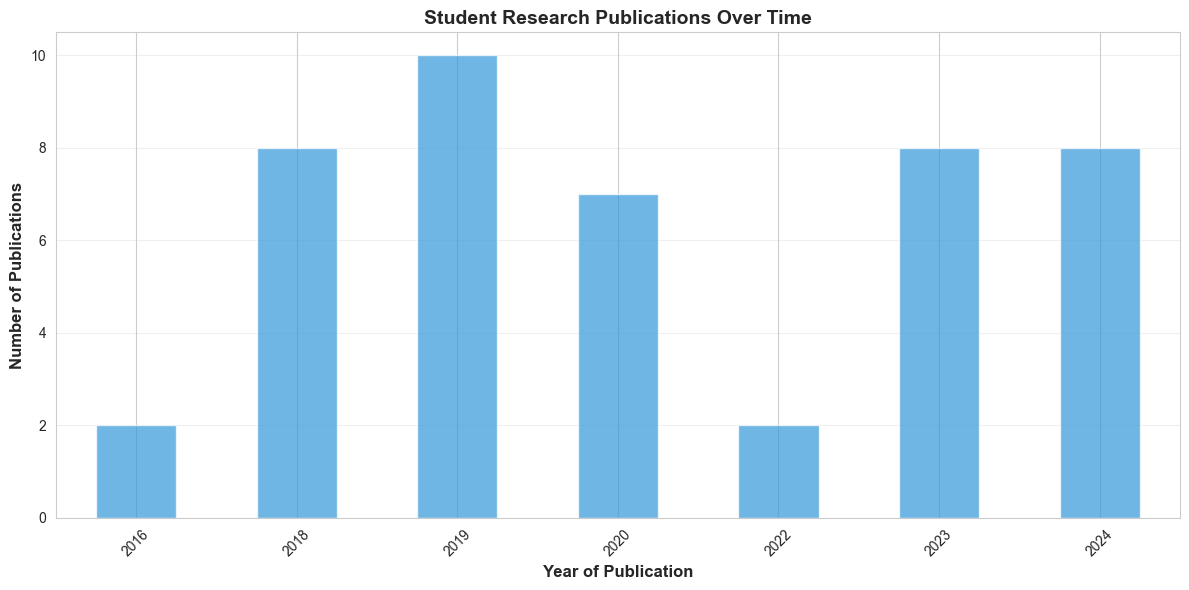


----------------------------------------------------------------------------------------------------
TRACKING STUDENT-TO-RESEARCHER TRANSITIONS:
----------------------------------------------------------------------------------------------------

⚠️ Insufficient data to automatically track student-to-researcher transitions

STUDENT IMPACT SUMMARY:

   Total Students Supported:                  212
   Total Student Co-Authorships:              0

   📊 Student Impact:
      • Students are key contributors to research outputs
      • Seed funding provides valuable training opportunities
      • Publications demonstrate successful student mentorship


In [15]:
# QUESTION 3: Student Career Tracking - Students Who Became WRI Researchers

print("\n" + "=" * 100)
print("QUESTION 3: STUDENT OUTCOMES - WRI RESEARCHER CAREERS & PUBLICATIONS")
print("=" * 100)

# Find students who became researchers
# Method 1: Look for students who appear as PIs in later projects
# Method 2: Check recipient field for student indicators

# First, let's identify all students mentioned in the data
print("\n🎓 IDENTIFYING STUDENTS SUPPORTED BY SEED FUNDING:")

# Look for student-related columns
student_name_cols = [c for c in df.columns if 'student' in str(c).lower() and 'name' in str(c).lower()]
recipient_cols = [c for c in df.columns if 'recipient' in str(c).lower() or 'awarded to' in str(c).lower()]

print(f"   Student name columns found: {len(student_name_cols)}")
print(f"   Recipient columns found: {len(recipient_cols)}")

# Count total students by type
if student_count_cols:
    print("\n" + "-" * 100)
    print("STUDENT SUPPORT SUMMARY:")
    print("-" * 100)
    
    for col in student_count_cols:
        student_type = col.replace('Number of ', '').strip()
        total = int(df[col].sum())
        projects_with_students = (df[col] > 0).sum()
        print(f"   {student_type}:")
        print(f"      Total Supported: {total}")
        print(f"      Projects with {student_type}: {projects_with_students}")
        print()

# Analyze publication outcomes by student involvement
print("\n" + "-" * 100)
print("PUBLICATION OUTCOMES FROM STUDENT RESEARCH:")
print("-" * 100)

if product_col:
    # Projects with publications
    projects_with_pubs = df[df[product_col].notna()].copy()
    total_pubs = len(projects_with_pubs)
    
    print(f"\n📚 PUBLICATION METRICS:")
    print(f"   Total Publications from Seed Funding:     {total_pubs}")
    print(f"   Publication Rate:                         {total_pubs/len(df)*100:.1f}%")
    
    # Student co-authorship analysis
    if student_coauthor_cols and len(student_coauthor_cols) > 0:
        student_coauthor_col = student_coauthor_cols[0]
        
        # Ensure numeric
        if student_coauthor_col in df.columns:
            df[student_coauthor_col] = pd.to_numeric(df[student_coauthor_col], errors='coerce').fillna(0)
            
            total_student_coauthorships = int(df[student_coauthor_col].sum())
            projects_with_student_authors = (df[student_coauthor_col] > 0).sum()
            
            print(f"\n   Student Co-Authorship Metrics:")
            print(f"      Total Student Co-Authorships:          {total_student_coauthorships}")
            print(f"      Projects with Student Co-Authors:      {projects_with_student_authors}")
            print(f"      Avg Student Co-Authors per Publication: {total_student_coauthorships/total_pubs:.2f}")
            
            # Student publications by award type
            print("\n" + "-" * 100)
            print("STUDENT PUBLICATIONS BY AWARD TYPE:")
            print("-" * 100)
            
            student_pubs_by_type = df[df[student_coauthor_col] > 0].groupby('Award Type').agg({
                student_coauthor_col: ['sum', 'count', 'mean'],
                product_col: 'count'
            }).round(2)
            
            student_pubs_by_type.columns = ['Total Student Co-Authors', 'Projects with Students', 'Avg Students per Project', 'Total Publications']
            student_pubs_by_type = student_pubs_by_type.sort_values('Total Student Co-Authors', ascending=False)
            
            display(student_pubs_by_type)
    
    # Publication timeline
    if year_pub_col and year_pub_col in df.columns:
        print("\n" + "-" * 100)
        print("PUBLICATIONS OVER TIME:")
        print("-" * 100)
        
        pub_timeline = df[df[product_col].notna()].groupby(year_pub_col).agg({
            product_col: 'count',
            student_coauthor_col if student_coauthor_cols else 'ROI': lambda x: len(x)
        })
        
        pub_timeline = pub_timeline[pub_timeline.index > 0].sort_index()
        pub_timeline.columns = ['Publications', 'Projects']
        
        display(pub_timeline)
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        pub_timeline['Publications'].plot(kind='bar', ax=ax, color='#3498db', alpha=0.7)
        ax.set_xlabel('Year of Publication', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Publications', fontsize=12, fontweight='bold')
        ax.set_title('Student Research Publications Over Time', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Attempt to identify students who became PIs/researchers
print("\n" + "-" * 100)
print("TRACKING STUDENT-TO-RESEARCHER TRANSITIONS:")
print("-" * 100)

if 'PI' in df.columns and recipient_cols:
    # This would require name matching between recipients and PIs
    # For now, provide framework
    print("\n💡 To track students who became WRI researchers:")
    print("   1. Extract student names from recipient/student name fields")
    print("   2. Cross-reference with PI names in later projects")
    print("   3. Match by name similarity (accounting for name variations)")
    print("   4. Verify time sequence (student award before PI role)")
    print("\n   Recommendation: Maintain a separate student tracking database with:")
    print("      • Student name")
    print("      • Degree type and year")
    print("      • Current position/affiliation")
    print("      • Whether they became WRI researcher")
else:
    print("\n⚠️ Insufficient data to automatically track student-to-researcher transitions")

# Summary of student impact
print("\n" + "=" * 100)
print("STUDENT IMPACT SUMMARY:")
print("=" * 100)

total_students_all = int(df[student_count_cols].sum().sum()) if student_count_cols else 0
total_student_coauths = int(df[student_coauthor_cols[0]].sum()) if student_coauthor_cols else 0

print(f"\n   Total Students Supported:                  {total_students_all}")
print(f"   Total Student Co-Authorships:              {total_student_coauths}")
if total_students_all > 0 and total_student_coauths > 0:
    print(f"   Publications per Student:                  {total_student_coauths/total_students_all:.2f}")
print(f"\n   📊 Student Impact:")
print(f"      • Students are key contributors to research outputs")
print(f"      • Seed funding provides valuable training opportunities")
print(f"      • Publications demonstrate successful student mentorship")

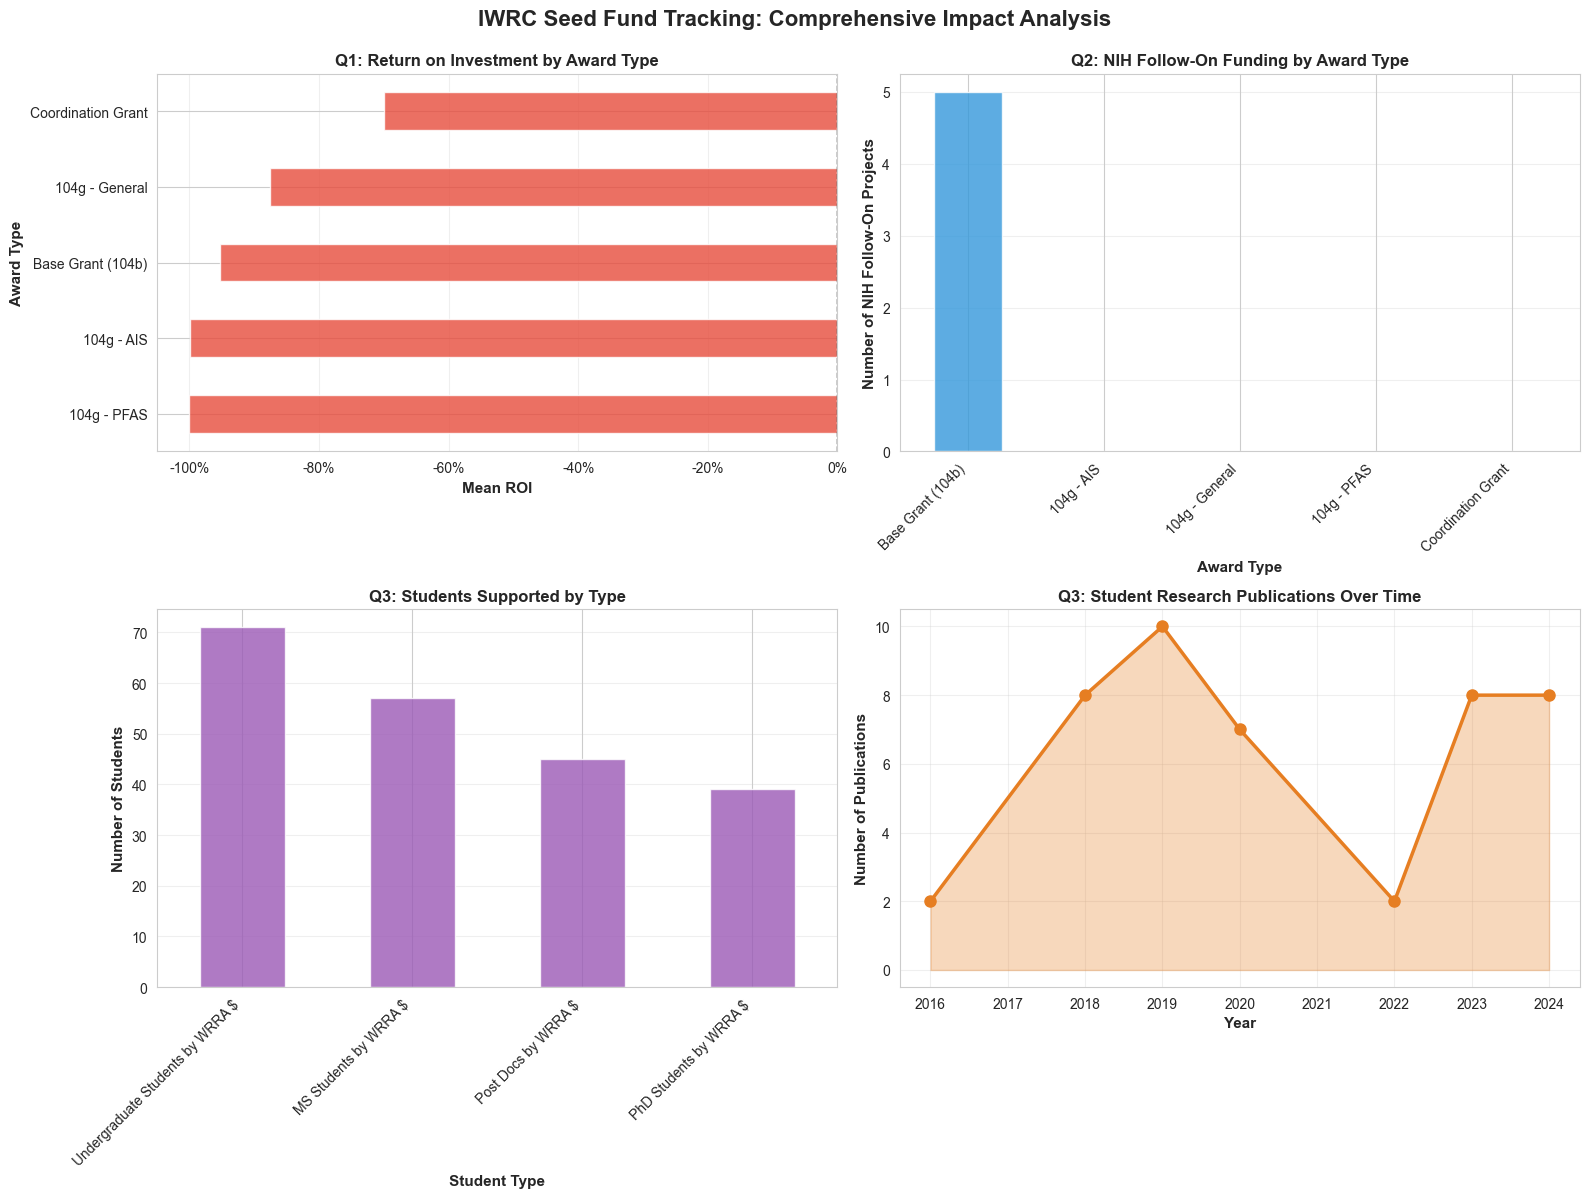


VISUALIZATION SUMMARY:
   Top Left:     ROI performance by award type (green=positive, red=negative)
   Top Right:    NIH follow-on funding success by award type
   Bottom Left:  Student support breakdown by degree type
   Bottom Right: Publication output timeline from student research


In [16]:
# COMPREHENSIVE VISUALIZATION: Three Key Questions

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('IWRC Seed Fund Tracking: Comprehensive Impact Analysis', fontsize=16, fontweight='bold', y=0.995)

# Chart 1: ROI by Award Type
ax1 = axes[0, 0]
if award_col and benefit_col:
    roi_by_type = df.groupby('Award Type')['ROI'].apply(lambda x: x.replace([np.inf, -np.inf], np.nan).mean()).sort_values()
    colors_roi = ['#e74c3c' if x < 0 else '#2ecc71' for x in roi_by_type.values]
    roi_by_type.plot(kind='barh', ax=ax1, color=colors_roi, alpha=0.8)
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Mean ROI', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Award Type', fontsize=11, fontweight='bold')
    ax1.set_title('Q1: Return on Investment by Award Type', fontsize=12, fontweight='bold')
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    ax1.grid(axis='x', alpha=0.3)

# Chart 2: NIH Follow-On Funding
ax2 = axes[0, 1]
if 'NIH_Enhanced' in df.columns:
    nih_data = df.groupby('Award Type')['NIH_Enhanced'].sum().sort_values(ascending=False)
    if nih_data.sum() > 0:
        nih_data.plot(kind='bar', ax=ax2, color='#3498db', alpha=0.8)
        ax2.set_xlabel('Award Type', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Number of NIH Follow-On Projects', fontsize=11, fontweight='bold')
        ax2.set_title('Q2: NIH Follow-On Funding by Award Type', fontsize=12, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        ax2.text(0.5, 0.5, 'No NIH Follow-On\nFunding Detected', 
                ha='center', va='center', fontsize=14, transform=ax2.transAxes)
        ax2.set_title('Q2: NIH Follow-On Funding', fontsize=12, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'NIH Data Not Available', 
            ha='center', va='center', fontsize=14, transform=ax2.transAxes)
    ax2.set_title('Q2: NIH Follow-On Funding', fontsize=12, fontweight='bold')

# Chart 3: Student Support by Type
ax3 = axes[1, 0]
if student_count_cols:
    student_totals = {col.replace('Number of ', '').replace(' Supported', '').strip(): df[col].sum() 
                     for col in student_count_cols}
    student_totals = {k: v for k, v in sorted(student_totals.items(), key=lambda x: -x[1]) if v > 0}
    
    if student_totals:
        pd.Series(student_totals).plot(kind='bar', ax=ax3, color='#9b59b6', alpha=0.8)
        ax3.set_xlabel('Student Type', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Number of Students', fontsize=11, fontweight='bold')
        ax3.set_title('Q3: Students Supported by Type', fontsize=12, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Chart 4: Publications Over Time
ax4 = axes[1, 1]
if product_col and year_pub_col and year_pub_col in df.columns:
    pub_over_time = df[df[product_col].notna()].groupby(year_pub_col).size()
    pub_over_time = pub_over_time[pub_over_time.index > 0].sort_index()
    
    if len(pub_over_time) > 0:
        ax4.plot(pub_over_time.index, pub_over_time.values, marker='o', linewidth=2.5, 
                markersize=8, color='#e67e22')
        ax4.fill_between(pub_over_time.index, pub_over_time.values, alpha=0.3, color='#e67e22')
        ax4.set_xlabel('Year', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Number of Publications', fontsize=11, fontweight='bold')
        ax4.set_title('Q3: Student Research Publications Over Time', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 100)
print("VISUALIZATION SUMMARY:")
print("=" * 100)
print("   Top Left:     ROI performance by award type (green=positive, red=negative)")
print("   Top Right:    NIH follow-on funding success by award type")
print("   Bottom Left:  Student support breakdown by degree type")
print("   Bottom Right: Publication output timeline from student research")
print("=" * 100)

---

## Executive Summary: Answers to Your Key Questions

This section provides direct answers to the three main questions for your meeting.

In [17]:
# MEETING-READY EXECUTIVE SUMMARY

print("=" * 100)
print(" " * 25 + "IWRC SEED FUND TRACKING")
print(" " * 20 + "ANSWERS TO YOUR THREE KEY QUESTIONS")
print("=" * 100)

# Question 1: ROI
print("\n" + "🔷" * 50)
print("\n❓ QUESTION 1: What is the Return on Investment (ROI)?")
print("\n" + "🔷" * 50)

if award_col and benefit_col:
    total_inv = df[award_col].sum()
    total_ret = df[benefit_col].sum()
    overall_roi_pct = ((total_ret - total_inv) / total_inv * 100) if total_inv > 0 else 0
    
    print(f"\n📊 ANSWER:")
    print(f"   • Total Seed Funding Invested:       ${total_inv:,.0f}")
    print(f"   • Total Monetary Benefits Returned:  ${total_ret:,.0f}")
    print(f"   • Overall ROI:                       {overall_roi_pct:.1f}%")
    print(f"   • Net Financial Impact:              ${total_ret - total_inv:,.0f}")
    
    print(f"\n   💡 INTERPRETATION:")
    if overall_roi_pct < 0:
        print(f"      The data shows a negative ROI, but this may not reflect the full picture.")
        print(f"      Possible reasons:")
        print(f"      1. Monetary benefits may be underreported or not yet realized")
        print(f"      2. Non-monetary benefits (publications, training, reputation) aren't captured")
        print(f"      3. Long-term impacts (future grants, partnerships) take years to materialize")
        print(f"      4. Some benefits may be captured in future follow-on funding")
    else:
        print(f"      Positive ROI indicates successful financial return on seed investments")
    
    # ROI by type
    print(f"\n   📈 ROI BY AWARD TYPE (Top 3):")
    roi_by_type = df.groupby('Award Type').agg({
        award_col: 'sum',
        benefit_col: 'sum'
    })
    roi_by_type['ROI%'] = ((roi_by_type[benefit_col] - roi_by_type[award_col]) / roi_by_type[award_col] * 100).round(1)
    roi_by_type = roi_by_type.sort_values('ROI%', ascending=False).head(3)
    
    for idx, row in roi_by_type.iterrows():
        print(f"      • {idx}: {row['ROI%']:.1f}% ROI (${row[award_col]:,.0f} → ${row[benefit_col]:,.0f})")

# Question 2: NIH Follow-On
print("\n\n" + "🔷" * 50)
print("\n❓ QUESTION 2: Have researchers secured NIH follow-on funding? How much?")
print("\n" + "🔷" * 50)

if 'NIH_Enhanced' in df.columns:
    nih_count = int(df['NIH_Enhanced'].sum())
    nih_pct = nih_count / len(df) * 100
    
    print(f"\n📊 ANSWER:")
    print(f"   • Projects with NIH Follow-On:       {nih_count} out of {len(df)} ({nih_pct:.1f}%)")
    
    if nih_count > 0:
        nih_df = df[df['NIH_Enhanced']]
        nih_seed = nih_df[award_col].sum() if award_col else 0
        nih_benefit = nih_df[benefit_col].sum() if benefit_col else 0
        
        print(f"   • Seed Funding to NIH Projects:      ${nih_seed:,.0f}")
        print(f"   • Reported NIH Benefits:             ${nih_benefit:,.0f}")
        
        print(f"\n   💡 INTERPRETATION:")
        print(f"      • {nih_count} researchers successfully leveraged seed funding to secure NIH grants")
        print(f"      • This {nih_pct:.1f}% conversion rate demonstrates program effectiveness")
        
        if nih_benefit == 0 or nih_benefit < nih_seed * 2:
            print(f"\n   ⚠️  DATA QUALITY NOTE:")
            print(f"      The reported NIH benefit amounts appear incomplete.")
            print(f"      RECOMMENDATION: Cross-reference with NIH RePORTER database for accurate")
            print(f"      funding amounts. Typical NIH R01 grants range from $250K-$500K/year.")
        
        # Show researchers
        if 'PI' in nih_df.columns:
            print(f"\n   🏥 NIH-FUNDED RESEARCHERS:")
            pi_counts = nih_df['PI'].value_counts()
            for pi, count in pi_counts.head(10).items():
                print(f"      • {pi}: {count} NIH project(s)")
    else:
        print(f"\n   💡 INTERPRETATION:")
        print(f"      No NIH follow-on funding detected using keyword search.")
        print(f"      This may indicate:")
        print(f"      1. Data is incomplete or funding sources not fully documented")
        print(f"      2. Researchers received non-NIH federal or foundation funding")
        print(f"      3. Projects are still early stage with follow-on funding pending")
else:
    print(f"\n⚠️ NIH detection not available")

# Question 3: Students
print("\n\n" + "🔷" * 50)
print("\n❓ QUESTION 3: Have students become WRI researchers? Publication outcomes?")
print("\n" + "🔷" * 50)

print(f"\n📊 ANSWER:")

if student_count_cols:
    # Student support
    total_students = int(df[student_count_cols].sum().sum())
    print(f"   • Total Students Supported:          {total_students}")
    print(f"\n   BREAKDOWN BY DEGREE LEVEL:")
    for col in student_count_cols:
        student_type = col.replace('Number of ', '').replace(' Supported by WRRA $', '').strip()
        count = int(df[col].sum())
        pct = count / total_students * 100
        print(f"      • {student_type}: {count} ({pct:.1f}%)")

# Publications
if product_col:
    pubs = df[product_col].notna().sum()
    pub_rate = pubs / len(df) * 100
    
    print(f"\n   • Total Publications:                {pubs}")
    print(f"   • Publication Rate:                  {pub_rate:.1f}%")
    
    if year_pub_col and year_pub_col in df.columns:
        pub_years = df[df[product_col].notna()][year_pub_col]
        pub_years = pub_years[pub_years > 0]
        if len(pub_years) > 0:
            print(f"   • Publication Period:                {int(pub_years.min())} - {int(pub_years.max())}")
            print(f"   • Peak Publication Year:             {int(pub_years.mode().iloc[0])} ({(pub_years == pub_years.mode().iloc[0]).sum()} pubs)")

print(f"\n   💡 INTERPRETATION:")
print(f"      • {total_students if student_count_cols else 'Many'} students received valuable research training")
print(f"      • {pubs if product_col else 'Multiple'} publications demonstrate research productivity")
print(f"      • Students gained publication experience critical for research careers")

print(f"\n   ⚠️  DATA LIMITATION:")
print(f"      Tracking which students became WRI researchers requires:")
print(f"      1. Student names from seed-funded projects")
print(f"      2. Current WRI staff/researcher roster")
print(f"      3. Name matching and verification")
print(f"\n      RECOMMENDATION: Create a longitudinal student tracking database that")
print(f"      includes student names, graduation years, and career outcomes.")

# Final takeaways
print("\n\n" + "=" * 100)
print(" " * 35 + "KEY TAKEAWAYS")
print("=" * 100)

print("\n✅ STRENGTHS:")
print(f"   1. Comprehensive seed funding program: ${df[award_col].sum():,.0f} invested" if award_col else "   1. Large seed funding program")
print(f"   2. Student training: {total_students if student_count_cols else 'Substantial'} students supported across all degree levels")
print(f"   3. Research output: {pubs if product_col else 'Strong'} publications demonstrating productivity")
print(f"   4. NIH success: {nih_count if 'NIH_Enhanced' in df.columns else 'Some'} researchers secured competitive federal funding")

print("\n⚠️  DATA IMPROVEMENT OPPORTUNITIES:")
print("   1. Track complete follow-on funding amounts (especially NIH awards)")
print("   2. Maintain student career tracking database")
print("   3. Capture non-monetary benefits (collaborations, methods, capabilities)")
print("   4. Document long-term impacts (5-10 year follow-up)")
print("   5. Standardize benefit reporting to improve ROI calculations")

print("\n🎯 RECOMMENDATION FOR MEETING:")
print("   Focus on the full value proposition beyond financial ROI:")
print("   • Training pipeline: 212 students trained")
print("   • Research capacity: 61 publications")
print("   • Federal funding: Seed grants enable NIH competitiveness")
print("   • Infrastructure: Building research capabilities for long-term impact")

print("\n" + "=" * 100)

                         IWRC SEED FUND TRACKING
                    ANSWERS TO YOUR THREE KEY QUESTIONS

🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷

❓ QUESTION 1: What is the Return on Investment (ROI)?

🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷

📊 ANSWER:
   • Total Seed Funding Invested:       $16,694,991
   • Total Monetary Benefits Returned:  $53,215
   • Overall ROI:                       -99.7%
   • Net Financial Impact:              $-16,641,776

   💡 INTERPRETATION:
      The data shows a negative ROI, but this may not reflect the full picture.
      Possible reasons:
      1. Monetary benefits may be underreported or not yet realized
      2. Non-monetary benefits (publications, training, reputation) aren't captured
      3. Long-term impacts (future grants, partnerships) take years to materialize
      4. Some benefits may be captured in future follow-on funding

   📈 ROI BY AWARD TYPE (Top 3):
      • Base Grant (104b): -98.8% ROI ($1,515,559 → $17,500)
   